In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import sys
import pyedflib

In [2]:
# --  parameters
run = 689612
tag = 479137724
det_shape  = [2399,2399]

# -- paths
file_path = '/UserData/fperakis/test_data/%s.h5'%run
tag_path = 'run_%s/detector_2d_assembled_1/'%run

In [3]:
# load h5 file
f = h5py.File(file_path, 'r')
tags = np.array(list(f[tag_path].keys())[1:])

In [4]:
# caclulate the average image
img = np.zeros(det_shape)
for i in range(len(tags)):
    img_path = tag_path + '%s/detector_data/'%tags[i]
    img += np.array(f[img_path])
img /= len(tags)

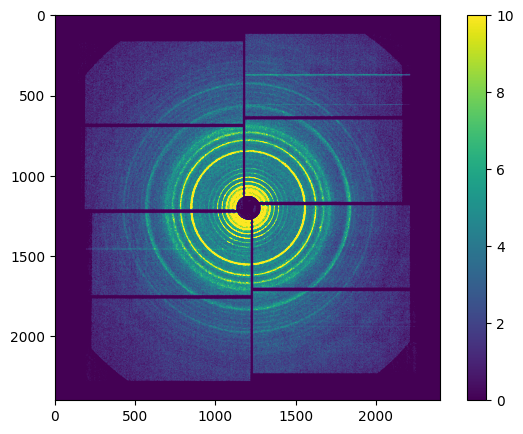

In [16]:
plt.figure(figsize=[7,5])
plt.imshow(img,vmin=0,vmax=10)
plt.colorbar()
plt.show()

In [25]:
file=pyedflib.EdfWriter('../../test.bdf', 2399, file_type=pyedflib.FILETYPE_BDFPLUS)
file.writeSamples(img)
file.close()open( header = read_header(fr)
    data_records = read_data_records(fr, header)
    
    

AttributeError: module 'edfrd' has no attribute 'open'

In [15]:
np.save('../../AgBh.npy',img)

In [ ]:
file.close()

1145348.h5            histograms_for_thresholds1D.ipynb         tag_1145459.lst
1145497_again.h5      histograms_for_thresholds2D.ipynb         tag_1145497.lst
1145497.h5            I_phi_q.ipynb                             tag_1145509.lst
1145509.h5            Iq_calculator.ipynb                       tag_1145510.lst
1145510.h5            Iq_calculator.py*                         tag_689610.lst
2D_images.ipynb       IqPhi_calculator.py                       tag_689941.lst
689610.h5             Mariia.py                                 tag_690016.lst
690016.h5             mask_maker.ipynb                          tag_690017.lst
690017.h5             mask.npy                                  tag_739129.lst
aqua/                 Old_avedata_polarisationCorrection.ipynb  test.bdf
Calibration.ipynb     SACLA_2022B8033/                          test.npy
data.h5               tag_1039128.lst                           untitled.txt
filter2D.ipynb        tag_1145348.lst
filter.ipynb.invalid  ta